# generals

In [1]:
# general libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import time
import requests
import json
import io

# analysis libraries
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from paretoset import paretoset

# visualization libraries
import plotly.express as px
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from PIL import Image
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [3]:
# directories
datasets_dir = "../../datasets/"

# datasets

In [4]:
# OSM data: we need to fix the coordinate reference system
data = gpd.read_file(datasets_dir + "geopoints_data.geojson")
data['lat_m'] = data.geometry.x
data['lon_m'] = data.geometry.y
data['node_id'] = data['node_id'].astype('string')

# RASTER DATA:
polygons = gpd.read_file(datasets_dir + "bologna_polygons.geojson")
polygons = polygons.to_crs('EPSG:32632')
polygons['id'] = polygons['id'].astype(str)

print("all datasets loaded")

all datasets loaded


In [5]:
polygons

,id,geometry
0,0,"POLYGON ((687085.679 4923677.699, 687040.585 4..."
1,1,"POLYGON ((691796.116 4928098.449, 691795.118 4..."
2,2,"POLYGON ((692735.175 4932802.702, 692714.316 4..."
3,3,"POLYGON ((678169.561 4930026.696, 678146.279 4..."
4,4,"POLYGON ((682122.038 4928729.725, 682088.36 49..."
5,5,"POLYGON ((687410.49 4929471.999, 687362.019 49..."
6,6,"POLYGON ((687362.019 4929910.751, 687410.49 49..."
7,7,"POLYGON ((686446.886 4930622.137, 686361.781 4..."


# functions setting

In [6]:
epsilon_parameter = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

min_elements_parameter = [2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20]

In [7]:
def compound_validity_index(dataset, model):
    
    # 0) Noise ratio -> we check how many data points are considere as noise by the algorithm
    labels = dataset['clusters'].values

    noise_ratio = np.sum(labels == -1) / len(labels)
    noise_norm = 1 - noise_ratio
    
    ### --- now we don't need the noise data anymore
    clustered_data = dataset[dataset['clusters'] != -1].copy()
    clustered_labels = clustered_data['clusters'].values
    
    ### ---

    # 1) Core Point Ratio (CPR)-> measures the density-connectedness of the clusters

    n_core = len(model.core_sample_indices_)
    core_ratio = n_core / (len(labels) - np.sum(labels == -1))

    ### ---
    
    # 2) Silouhette score -> check the compactness of results: how much clusters are densely distributed and well separated from each other
  
    sil_score = silhouette_score(clustered_data[['lat_m', 'lon_m']].values, clustered_labels)
    sil_norm = (sil_score + 1) / 2 # NORMALIZATION
    
    ### ---
    
    # 3) Davies-Boulin score -> measures for separation between clusters
    dbi_score = davies_bouldin_score(clustered_data[['lat_m', 'lon_m']].values, clustered_labels)
    dbi_norm = 1 - (dbi_score / (dbi_score + 1))

    ### ---
    
    # compound validity score
    cvs = np.mean([noise_norm, core_ratio, sil_norm, dbi_norm])
    
    
    res = [round(noise_norm, 2), round(core_ratio, 2), round(sil_norm, 2), round(dbi_norm, 2), round(cvs, 2)]
    
    return res
    

In [8]:
def dbscan_clustering(eps_value, el_value, dataset, grid, setting):
    
    # initialize clustering
    dbscan = DBSCAN(eps=eps_value*1000,# eps need to be settled in meters to fit the coordinates of data
                        min_samples=el_value,
                        algorithm='auto',
                        metric='euclidean')

    ids = dataset.node_id.values.astype(str)
    
    res = dbscan.fit(dataset[['lat_m', 'lon_m']]) # fit to the data directly
    clusters = res.labels_ # get the cluster labels
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # to exclude the noise cluster from the counting
    
    if num_clusters > 1:
        noise_ratio = (np.sum(clusters == -1) / len(clusters)).round(2)
        
        cluster_df = pd.DataFrame({'id': ids, "clusters": clusters})
        cluster_df['id'] = cluster_df['id'].astype("string") 
        complete_subset = dataset.merge(cluster_df, left_on='node_id',right_on="id", how='left')
        
        validation_metrics = compound_validity_index(complete_subset, dbscan)
        
        # STORE THE RESULTS
        res = [grid, setting, eps_value, el_value, num_clusters] + validation_metrics
        
        return res
    else: 
        #print("no cluster identified")
        pass

In [9]:
def dist_matrix_extraction(setting, polygon):
    
    current_matrix = pd.read_csv("datasets/matrix_computation/" + setting + "/polygon" + str(polygon) + ".csv", index_col=0)
    current_matrix.columns = current_matrix.columns.astype(int)
    
    return current_matrix

# DBSCAN clustering

In [10]:
columns = ['polygon_id', 'buffer', 'eps', 'el', 'clusters',
           'clus_score',
           'cor_score',
           'sil_score', 
           'dbi_score', 
           'cvs']


## ORIGINAL DATA

In [11]:
# it may take a while
data_original = []

for polygon in data.polygon_id.unique():
    
    # retrieve subset of data points
    matrix = dist_matrix_extraction("original", polygon)
    ids = [str(el) for el in matrix.index]
    subset = data[data.node_id.isin(ids)]
    
    for eps in epsilon_parameter:
        for el in min_elements_parameter:
            
            # compute the clustering on street
            current_res = dbscan_clustering(eps, el, subset, polygon, "original")
            if current_res is not None:
                data_original.append(current_res)
    

In [12]:
# turn into the results into dataframes
data_original = pd.DataFrame (data=data_original, columns=columns)

#check
data_original

,polygon_id,buffer,eps,el,clusters,clus_score,cor_score,sil_score,dbi_score,cvs
0,6,original,0.1,2,32,0.71,1.00,0.82,0.73,0.81
1,6,original,0.1,3,17,0.50,0.81,0.83,0.71,0.71
2,6,original,0.1,4,6,0.26,0.65,0.89,0.78,0.64
3,6,original,0.1,5,4,0.17,0.29,0.92,0.85,0.56
4,6,original,0.2,2,10,0.98,1.00,0.46,0.56,0.75
...,...,...,...,...,...,...,...,...,...,...
331,2,original,0.6,10,2,0.75,0.62,0.86,0.72,0.74
332,2,original,0.7,7,2,0.86,0.88,0.81,0.67,0.80
333,2,original,0.7,8,2,0.86,0.88,0.81,0.67,0.80
334,2,original,0.7,9,2,0.86,0.75,0.81,0.67,0.77


## 100 M BUFFERED DATA

In [26]:
# it may take a while
data_buffer100 = []

for polygon in data.polygon_id.unique():
    
    # retrieve subset of data points
    matrix = dist_matrix_extraction("buffer_100", polygon)
    ids = [str(el) for el in matrix.index]
    subset = data[data.node_id.isin(ids)]
    
    for eps in epsilon_parameter:
        for el in min_elements_parameter:
            
            # compute the clustering on street
            current_res = dbscan_clustering(eps, el, subset, polygon, "buffer_100")
            if current_res is not None:
                data_buffer100.append(current_res)
    

In [27]:
# turn into the results into dataframes
data_buffer100 = pd.DataFrame (data=data_buffer100, columns=columns)
#check
data_buffer100

,polygon_id,buffer,eps,el,clusters,clus_score,cor_score,sil_score,dbi_score,cvs
0,6,buffer_100,0.1,2,34,0.69,1.00,0.82,0.73,0.81
1,6,buffer_100,0.1,3,18,0.48,0.79,0.83,0.71,0.70
2,6,buffer_100,0.1,4,6,0.24,0.65,0.89,0.78,0.64
3,6,buffer_100,0.1,5,4,0.15,0.29,0.92,0.85,0.55
4,6,buffer_100,0.2,2,10,0.95,1.00,0.46,0.56,0.74
...,...,...,...,...,...,...,...,...,...,...
345,2,buffer_100,0.6,10,2,0.71,0.59,0.85,0.72,0.72
346,2,buffer_100,0.7,7,2,0.84,0.85,0.81,0.67,0.79
347,2,buffer_100,0.7,8,2,0.84,0.85,0.81,0.67,0.79
348,2,buffer_100,0.7,9,2,0.84,0.69,0.81,0.67,0.75


## 200 M BUFFER DATA

In [29]:
# it may take a while
data_buffer200 = []

for polygon in data.polygon_id.unique():
    
    # retrieve subset of data points
    matrix = dist_matrix_extraction("buffer_200", polygon)
    ids = [str(el) for el in matrix.index]
    subset = data[data.node_id.isin(ids)]
    
    for eps in epsilon_parameter:
        for el in min_elements_parameter:
            
            # compute the clustering on street
            current_res = dbscan_clustering(eps, el, subset, polygon, "buffer_200")
            if current_res is not None:
                data_buffer200.append(current_res)
    

In [30]:
# turn into the results into dataframes
data_buffer200 = pd.DataFrame (data=data_buffer200, columns=columns )

#check
data_buffer200

,polygon_id,buffer,eps,el,clusters,clus_score,cor_score,sil_score,dbi_score,cvs
0,6,buffer_200,0.1,2,35,0.68,1.00,0.82,0.73,0.81
1,6,buffer_200,0.1,3,20,0.50,0.78,0.83,0.71,0.71
2,6,buffer_200,0.1,4,7,0.25,0.69,0.88,0.78,0.65
3,6,buffer_200,0.1,5,5,0.17,0.34,0.93,0.85,0.58
4,6,buffer_200,0.2,2,11,0.94,1.00,0.45,0.56,0.74
...,...,...,...,...,...,...,...,...,...,...
357,2,buffer_200,0.6,10,2,0.71,0.59,0.85,0.72,0.72
358,2,buffer_200,0.7,7,2,0.84,0.85,0.81,0.67,0.79
359,2,buffer_200,0.7,8,2,0.84,0.85,0.81,0.67,0.79
360,2,buffer_200,0.7,9,2,0.84,0.69,0.81,0.67,0.75


# result comparison

## Separation metric vs Silhouette score

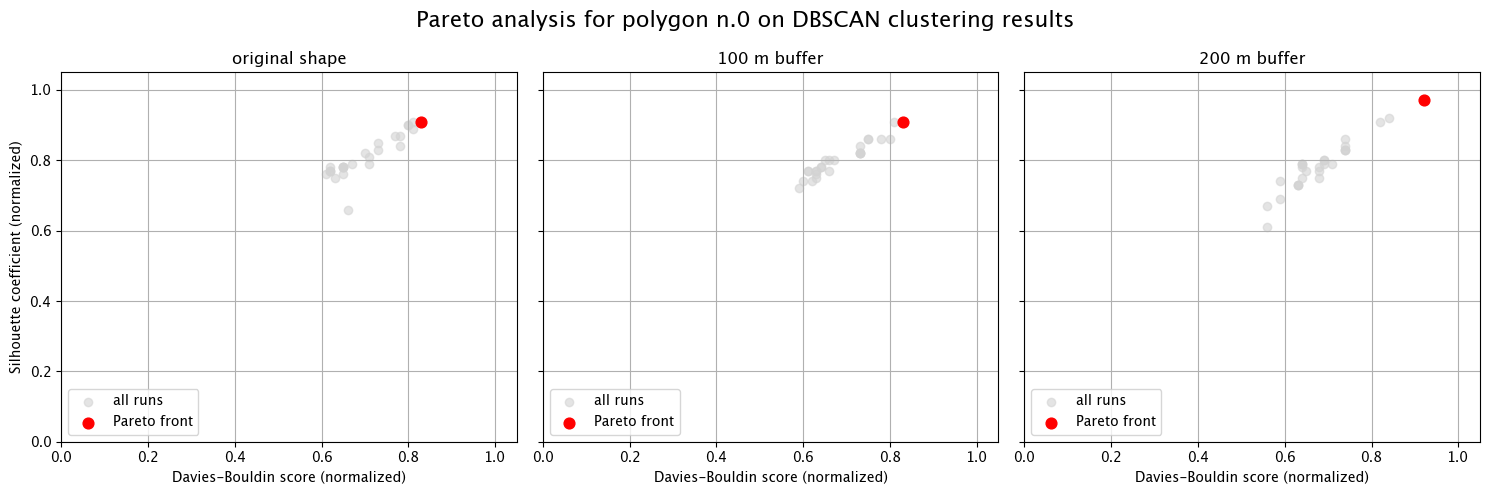

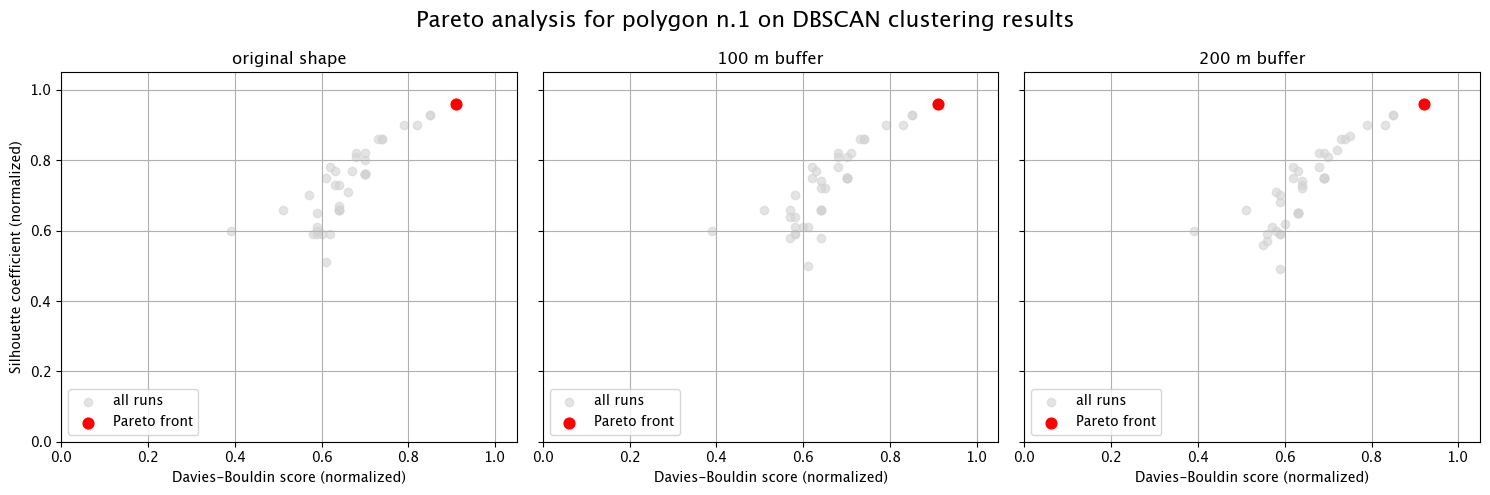

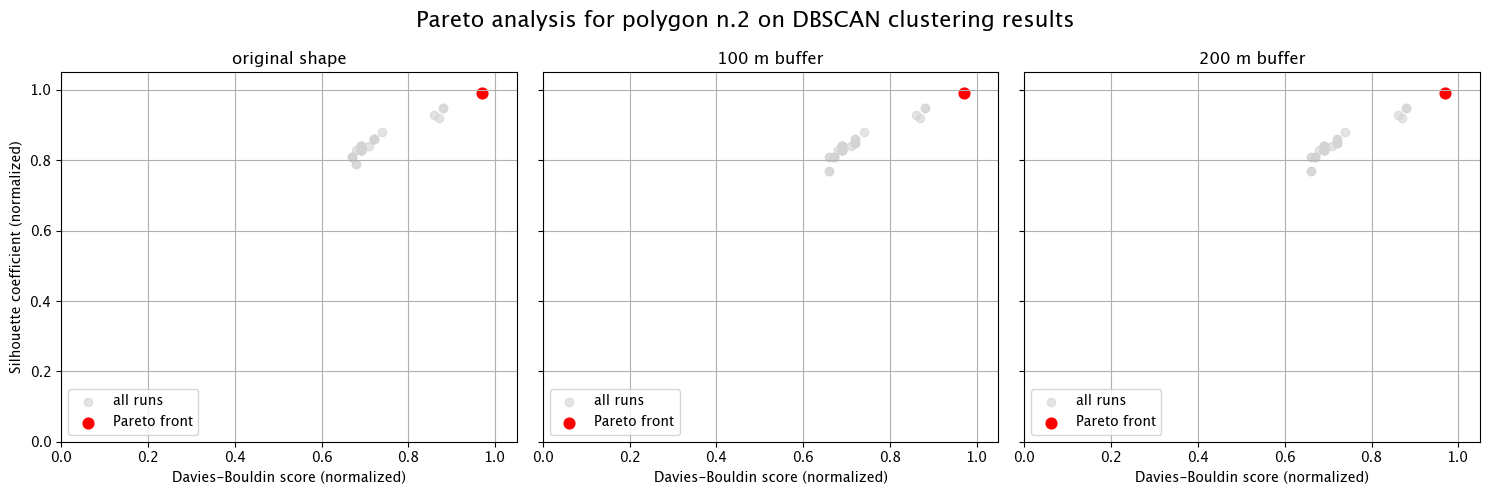

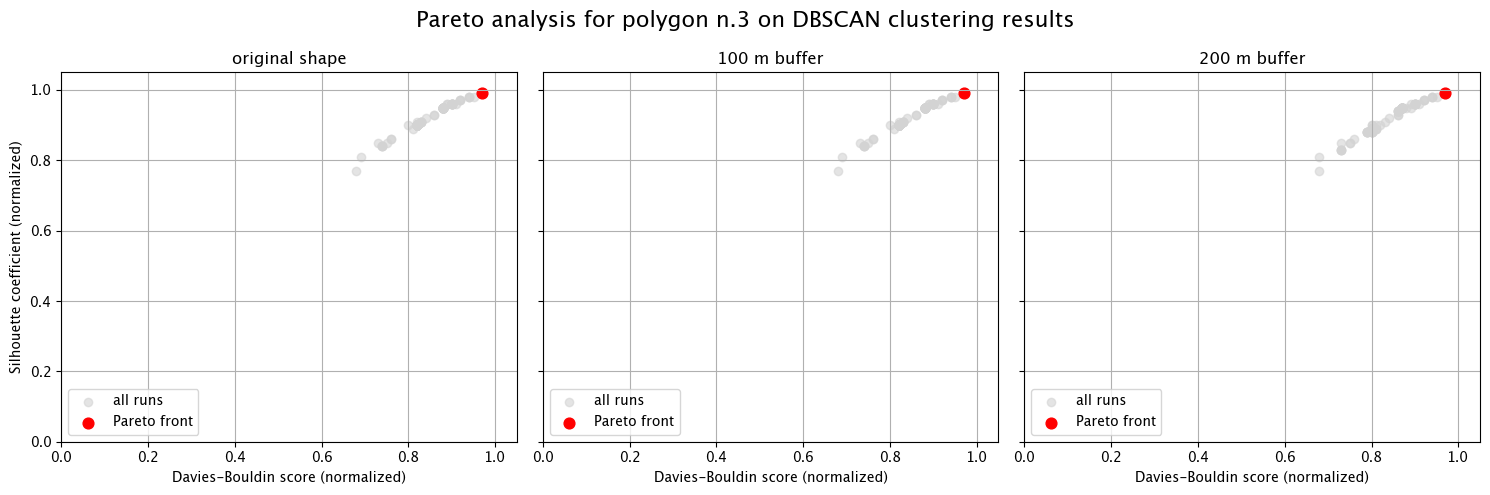

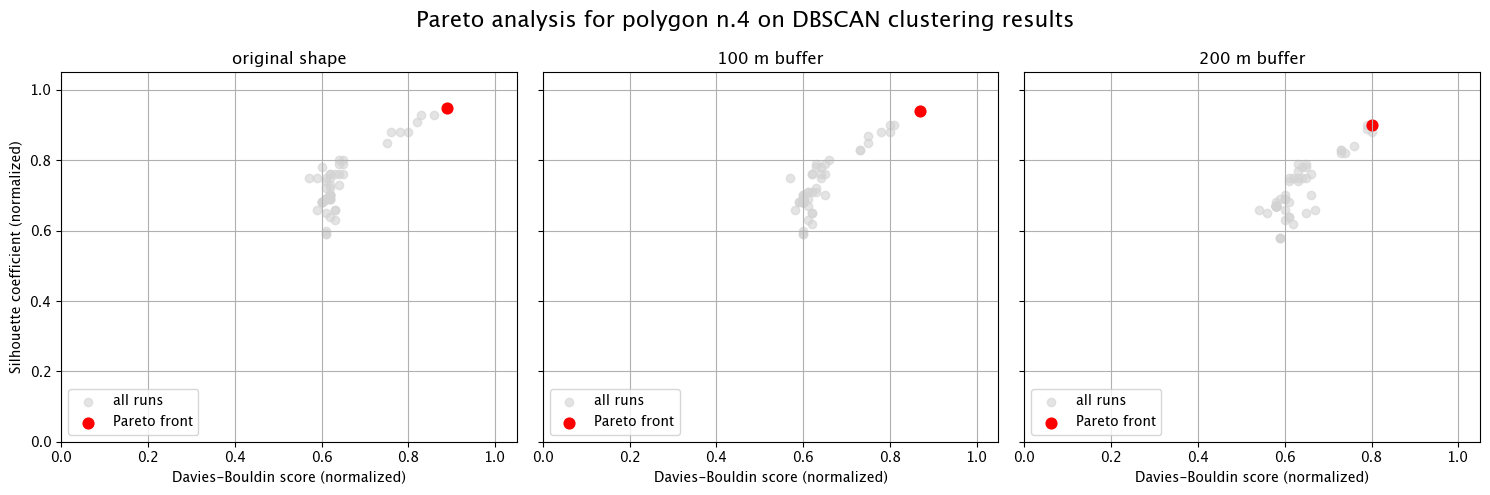

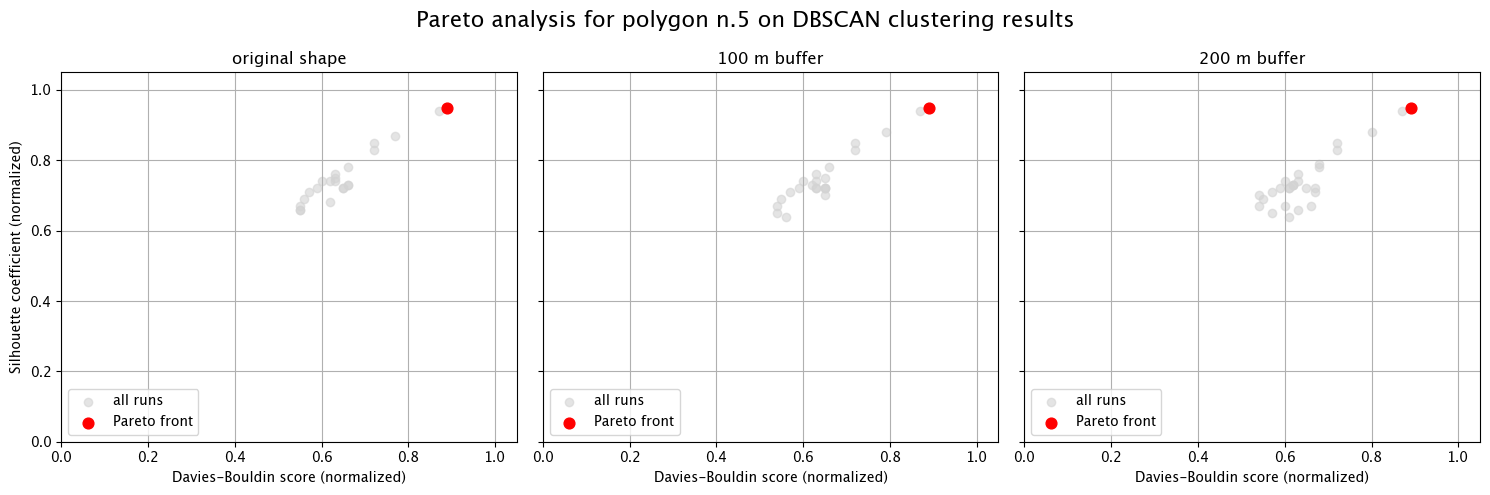

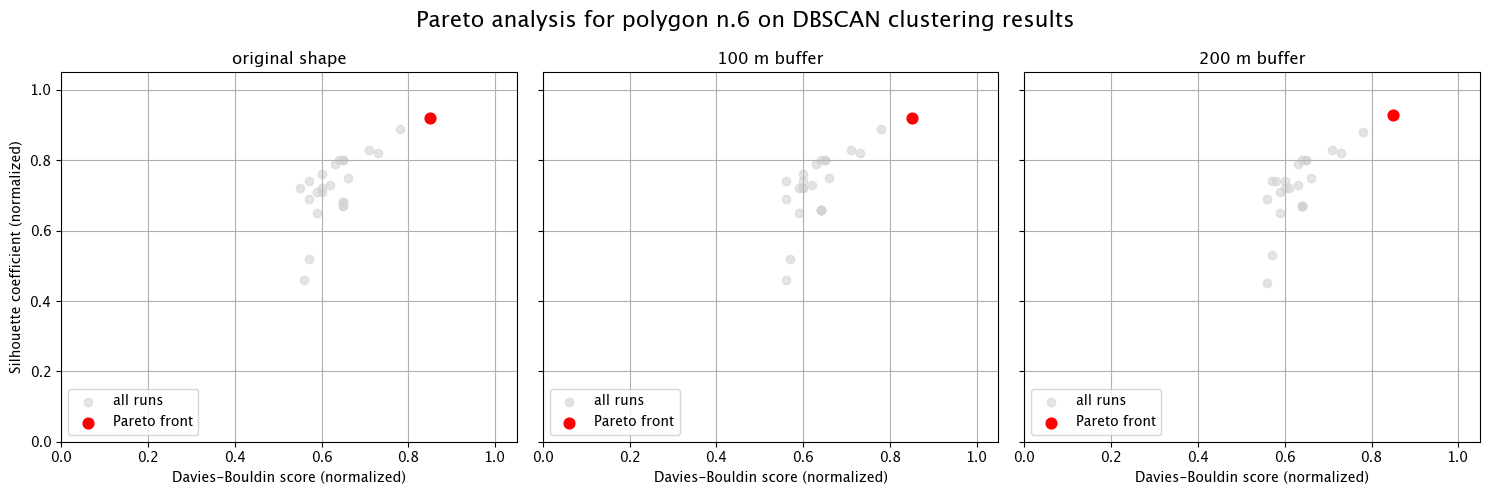

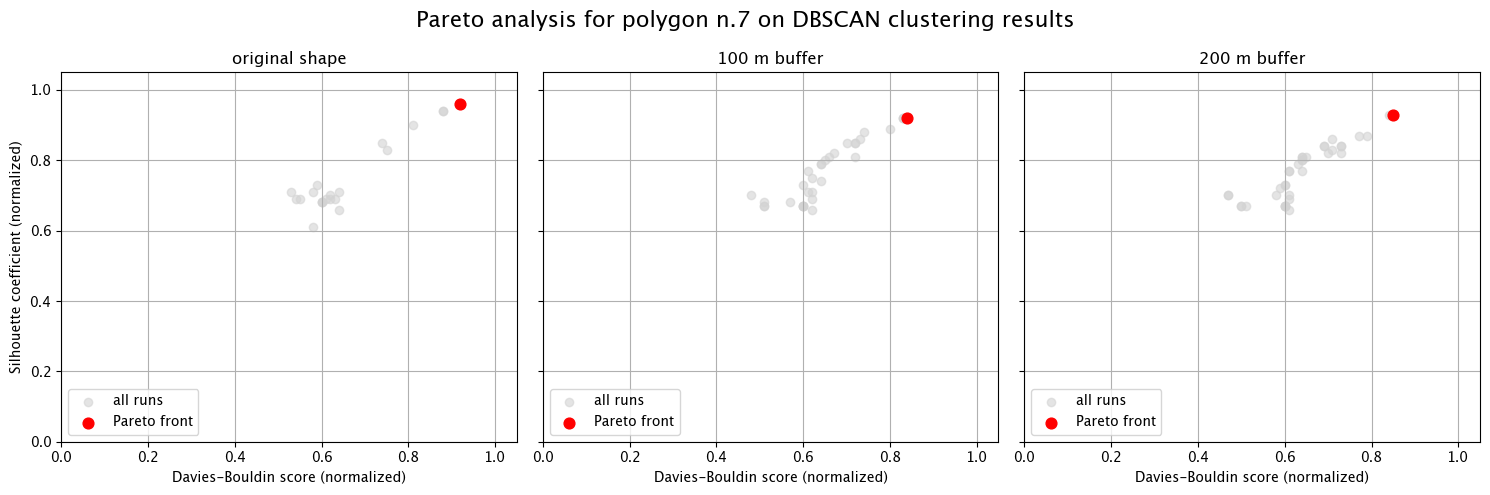

In [31]:
for pol in sorted(data.polygon_id.unique()):
    
    # filtering based on polygon
    res_original = data_original[data_original['polygon_id'] == pol].copy()
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].copy()
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].copy()
    
    # objectives to maximize -> only two for the plot
    objectives = ['dbi_score', 'sil_score']
    
    # computation of Pareto fronts separately
    pareto_mask_original = paretoset(res_original[objectives], sense=["max", "max"])
    pareto_mask_buffer100 = paretoset(res_buffer100[objectives], sense=["max", "max"])
    pareto_mask_buffer200 = paretoset(res_buffer200[objectives], sense=["max", "max"])
    
    # saving momentarily the results
    res_original_pareto = res_original[pareto_mask_original]
    res_buffer100_pareto = res_buffer100[pareto_mask_buffer100]
    res_buffer200_pareto = res_buffer200[pareto_mask_buffer200]
    
    # plotting for comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    datasets = [
        (res_original, res_original_pareto, "original shape", axes[0]),
        (res_buffer100, res_buffer100_pareto, "100 m buffer", axes[1]),
        (res_buffer200, res_buffer200_pareto, "200 m buffer", axes[2]),
    ]
    
    for full, pareto, title, ax in datasets:
        ax.scatter(full['dbi_score'], full['sil_score'], color='lightgray', label='all runs', alpha=0.6)
        ax.scatter(pareto['dbi_score'], pareto['sil_score'], color='red', label='Pareto front', s=60)
        ax.set_xlabel('Davies-Bouldin score (normalized)')
        ax.set_xlim(0.0, 1.05)
        ax.set_ylim(0.0, 1.05)
        ax.legend(loc='lower left')
        ax.set_title(title)
        ax.grid(True)
    
    axes[0].set_ylabel('Silhouette coefficient (normalized)')
    fig.suptitle(f"Pareto analysis for polygon n.{pol} on DBSCAN clustering results", fontsize=16)
    
    plt.tight_layout()
    plt.show()

## Silhouette score vs Cluster ratio

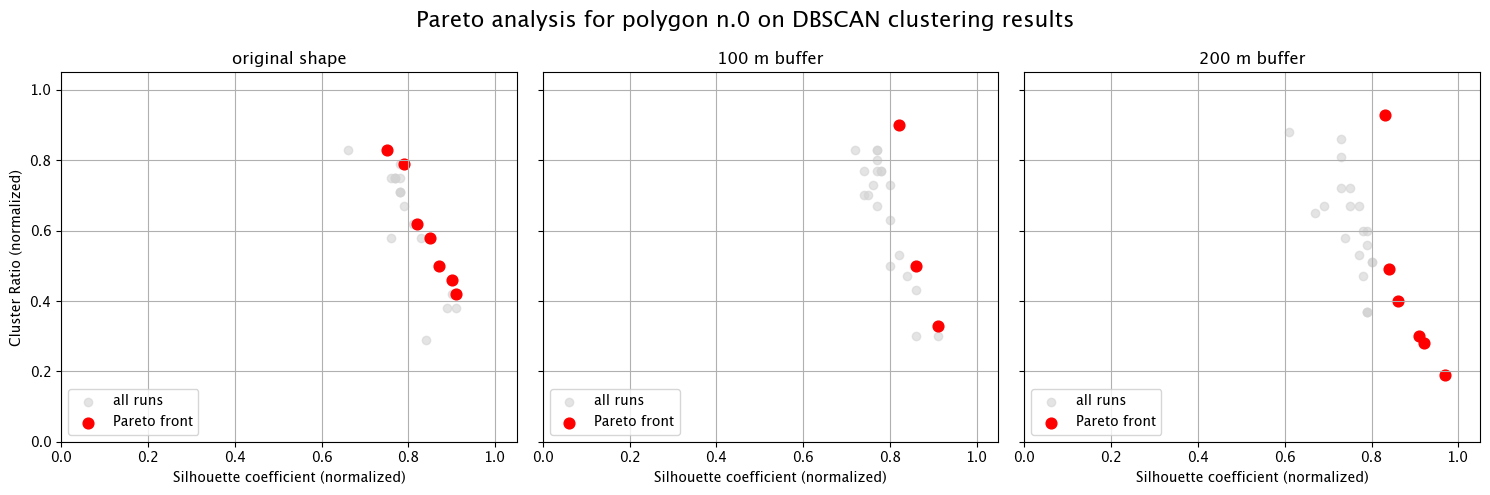

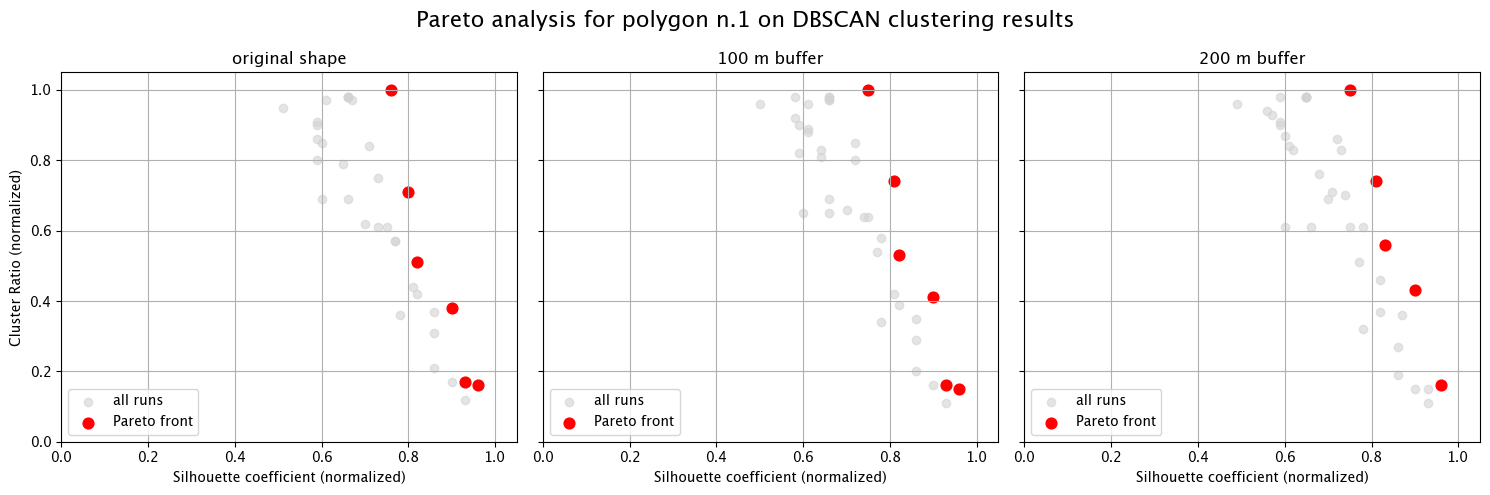

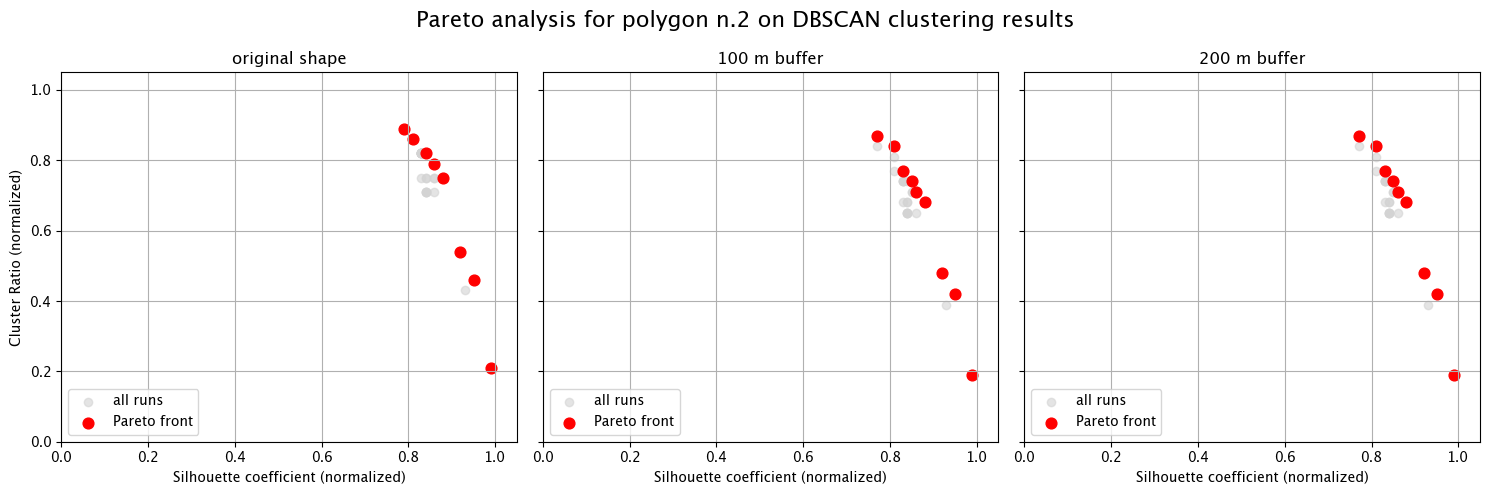

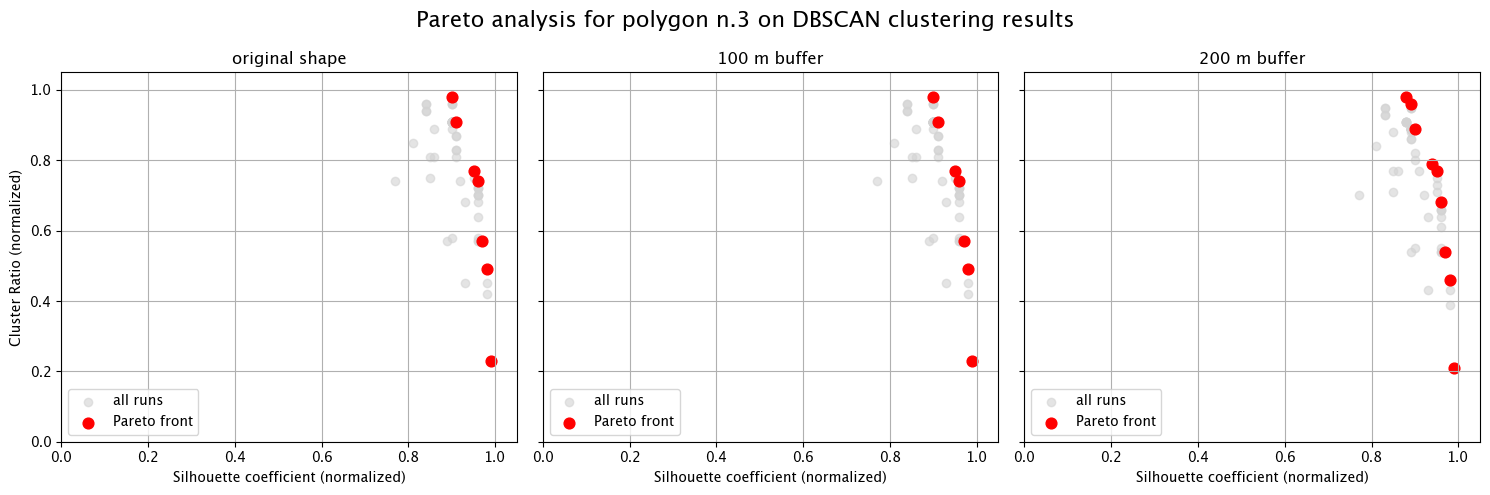

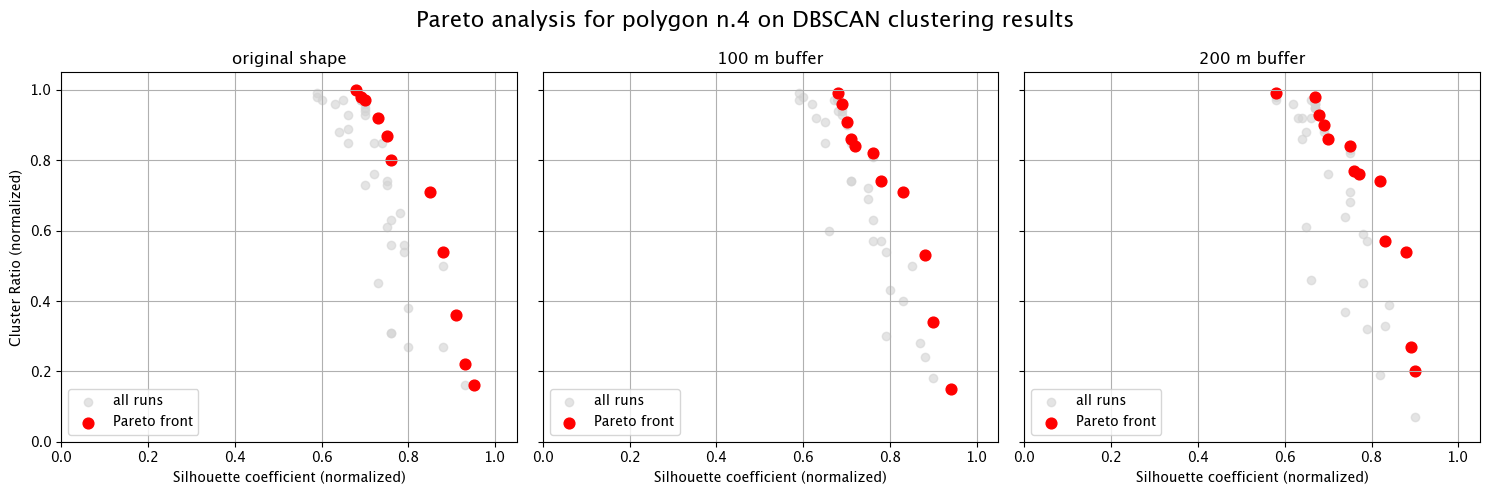

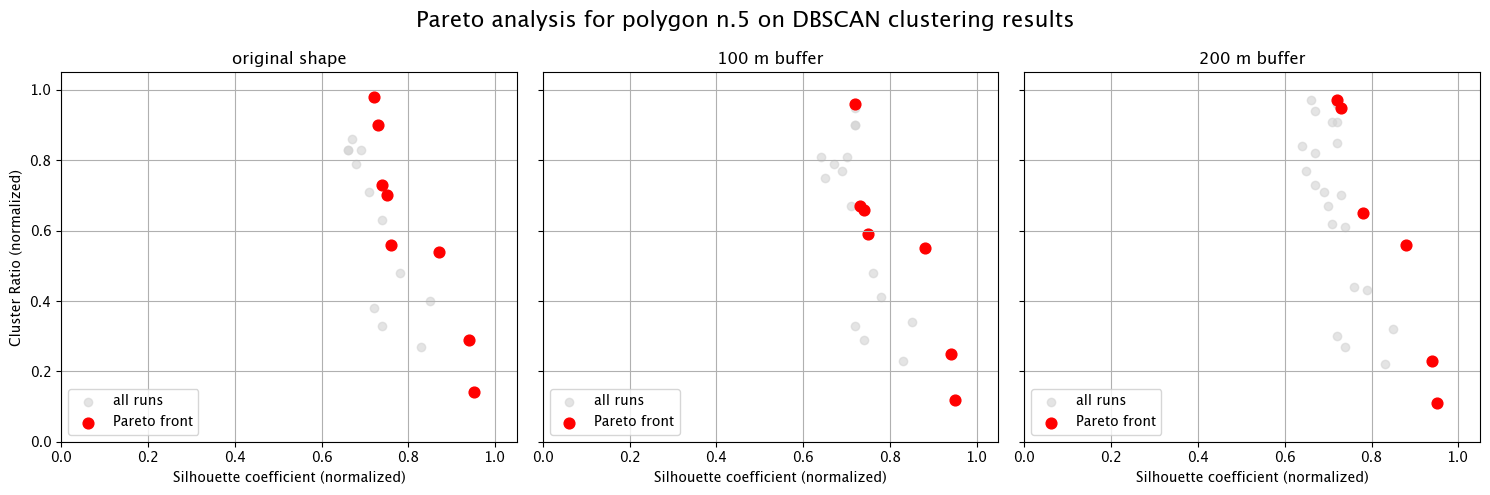

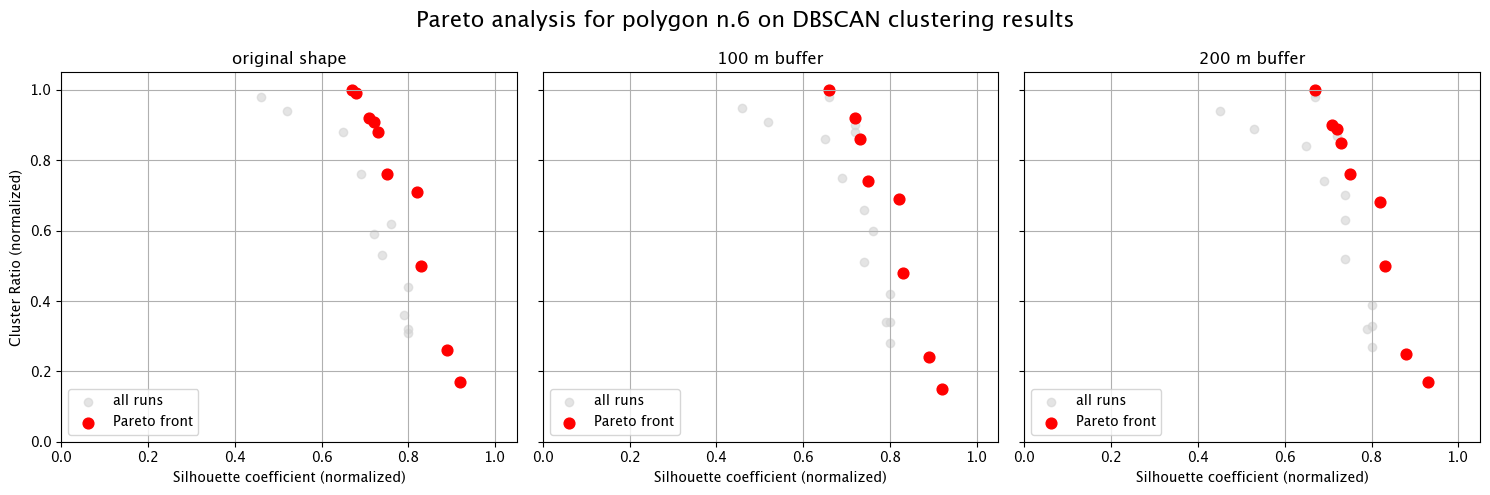

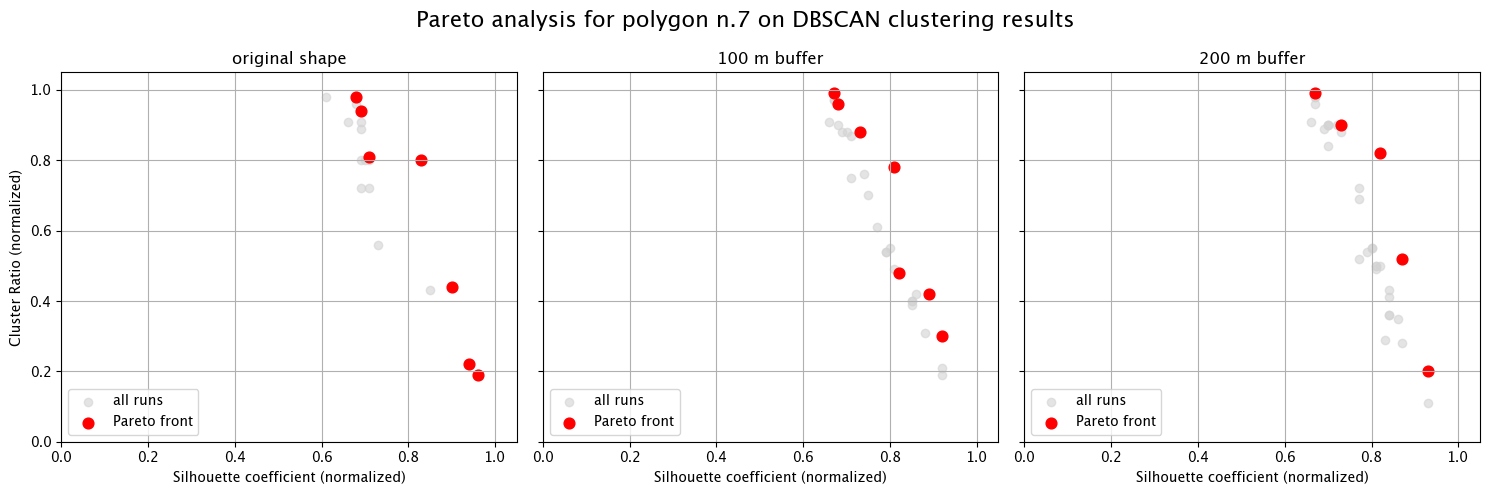

In [32]:
for pol in sorted(data.polygon_id.unique()):
    
    # filtering based on polygon
    res_original = data_original[data_original['polygon_id'] == pol].copy()
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].copy()
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].copy()
    
    # objectives to maximize -> only two for the plot
    objectives = ['sil_score', 'clus_score']
    
    # computation of Pareto fronts separately
    pareto_mask_original = paretoset(res_original[objectives], sense=["max", "max"])
    pareto_mask_buffer100 = paretoset(res_buffer100[objectives], sense=["max", "max"])
    pareto_mask_buffer200 = paretoset(res_buffer200[objectives], sense=["max", "max"])
    
    # saving momentarily the results
    res_original_pareto = res_original[pareto_mask_original]
    res_buffer100_pareto = res_buffer100[pareto_mask_buffer100]
    res_buffer200_pareto = res_buffer200[pareto_mask_buffer200]
    
    # plotting for comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    datasets = [
        (res_original, res_original_pareto, "original shape", axes[0]),
        (res_buffer100, res_buffer100_pareto, "100 m buffer", axes[1]),
        (res_buffer200, res_buffer200_pareto, "200 m buffer", axes[2]),
    ]
    
    for full, pareto, title, ax in datasets:
        ax.scatter(full['sil_score'], full['clus_score'], color='lightgray', label='all runs', alpha=0.6)
        ax.scatter(pareto['sil_score'], pareto['clus_score'], color='red', label='Pareto front', s=60)
        ax.set_xlabel('Silhouette coefficient (normalized)')
        ax.set_xlim(0.0, 1.05)
        ax.set_ylim(0.0, 1.05)
        ax.legend(loc='lower left')
        ax.set_title(title)
        ax.grid(True)
    
    axes[0].set_ylabel('Cluster Ratio (normalized)')
    fig.suptitle(f"Pareto analysis for polygon n.{pol} on DBSCAN clustering results", fontsize=16)
    
    plt.tight_layout()
    plt.show()

## four-dimensional pareto analysis

In [33]:
pareto_general_results = []

for pol in sorted(data.polygon_id.unique()):
    
    # filtering based on the polygon
    res_original = data_original[data_original['polygon_id'] == pol].copy()
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].copy()
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].copy()
    
    objectives = ['dbi_score', 'clus_score', 'sil_score', 'cor_score']
    
    # Pareto computation
    pareto_mask_original = paretoset(res_original[objectives], sense=["max", "max", "max", "max"])
    pareto_mask_buffer100 = paretoset(res_buffer100[objectives], sense=["max", "max", "max", "max"])
    pareto_mask_buffer200 = paretoset(res_buffer200[objectives], sense=["max", "max", "max", "max"])
    
    # print see the results
    res_original_pareto = res_original[pareto_mask_original]
    res_buffer100_pareto = res_buffer100[pareto_mask_buffer100]
    res_buffer200_pareto = res_buffer200[pareto_mask_buffer200]
                                         
    # considering only the best ten results based on N (number of elements clustered)
    res_original_sorted = res_original_pareto.sort_values(by="cvs", ascending=False).head(10)
    res_buffer100_sorted = res_buffer100_pareto.sort_values(by="cvs", ascending=False).head(10)
    res_buffer200_sorted = res_buffer200_pareto.sort_values(by="cvs", ascending=False).head(10)
    
    
    # now we combine all the results obtained together
    best_results = pd.concat([res_original_sorted, res_buffer100_sorted, res_buffer200_sorted], ignore_index=True)
    
    # store them together                                    
    pareto_general_results.append(best_results)                                     
                                         
                                         
                                         
pareto_complete = pd.concat(pareto_general_results, ignore_index=True)  
                                         
# check
pareto_complete                                       

,polygon_id,buffer,eps,el,clusters,clus_score,cor_score,sil_score,dbi_score,cvs
0,0,original,0.6,2,4,0.79,1.00,0.79,0.71,0.82
1,0,original,0.7,2,3,0.83,1.00,0.75,0.63,0.80
2,0,original,0.4,2,3,0.50,1.00,0.87,0.78,0.79
3,0,original,0.8,2,2,0.83,1.00,0.66,0.66,0.79
4,0,original,0.3,2,3,0.38,1.00,0.89,0.81,0.77
...,...,...,...,...,...,...,...,...,...,...
211,7,buffer_200,0.4,5,3,0.90,0.85,0.72,0.59,0.77
212,7,buffer_200,0.3,4,6,0.84,0.84,0.70,0.61,0.75
213,7,buffer_200,0.4,6,5,0.88,0.67,0.73,0.60,0.72
214,7,buffer_200,0.5,10,3,0.90,0.60,0.73,0.60,0.71


In [34]:
# store the results for following computations
result_path = os.path.join(datasets_dir, "pareto_dbscaneu.csv")
pareto_complete.to_csv(result_path)

print(f"dataset stored in directory: {result_path}")

dataset stored in directory: datasets/pareto_dbscaneu.csv


### heatmap results

In [35]:
def cleanup_format(x):
    
    return f"{x:.2f}"

In [36]:
 # --- define helper to plot and circle pareto points ---
def plot_heatmap_with_pareto(ax, pivot, annots, title, pareto_df):
    sns.heatmap(pivot, 
                    ax=ax, 
                    cmap='Greens', 
                    annot=annots, 
                    annot_kws={"size": 7},
                    fmt="", 
                    cbar=False,
                    vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("epsilon")
    ax.tick_params(axis='x', rotation=90)
    ax.invert_yaxis()

    # circle pareto points that exist in this pivot
    for _, p in pareto_df.iterrows():
        eps = p['eps']
        el = p['el']
        # check that (eps, el) exists in pivot table
        if eps in pivot.columns and el in pivot.index and not pd.isna(pivot.loc[el, eps]):
            x = list(pivot.columns).index(eps)
            y = list(pivot.index).index(el)
            circle = mpatches.Circle((x + 0.5, y + 0.5), radius=0.45, fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(circle)

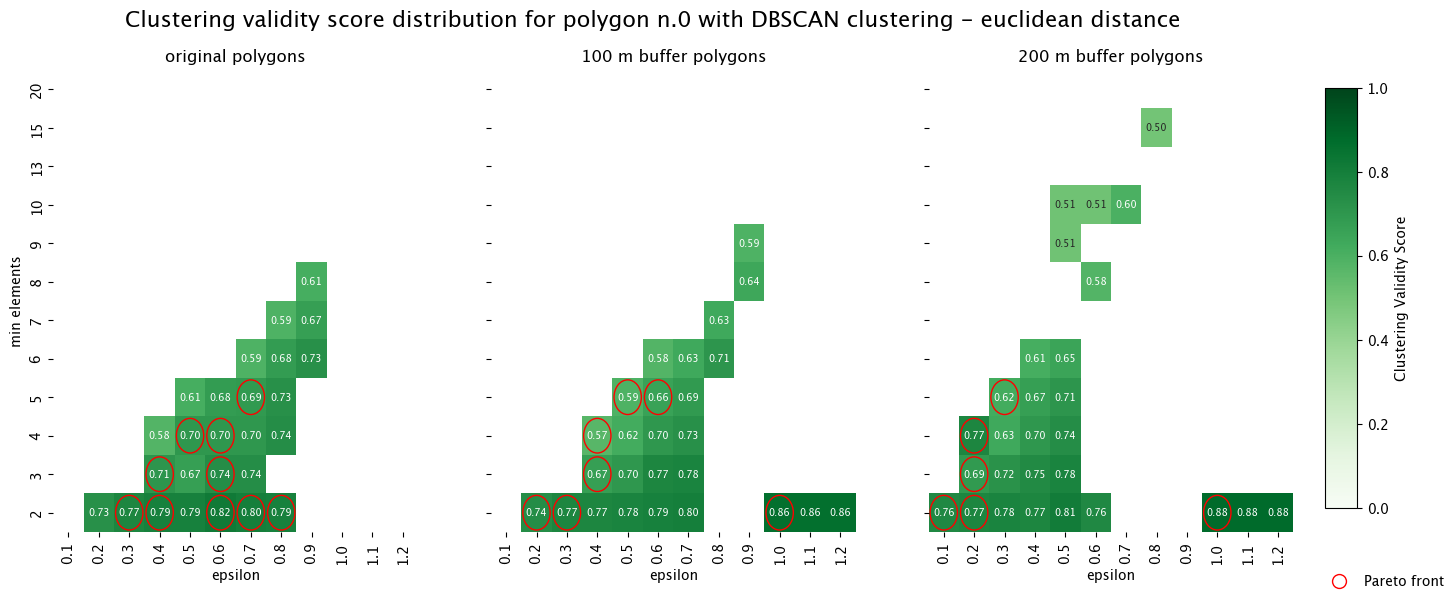

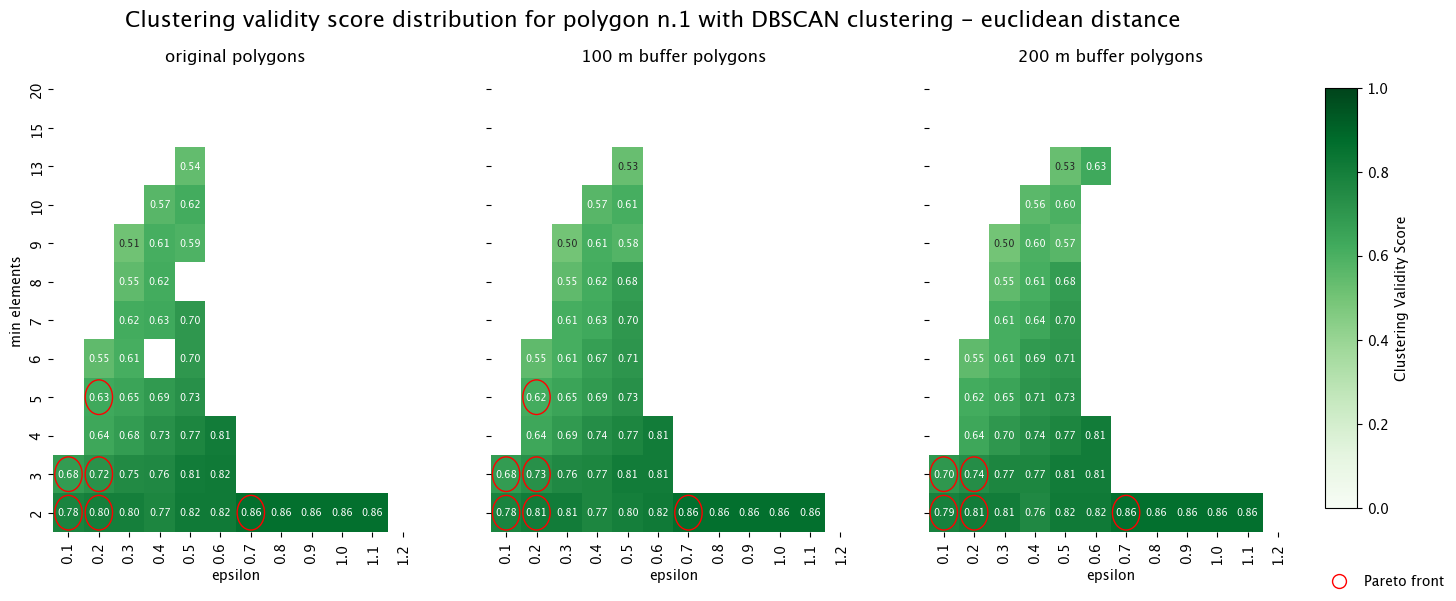

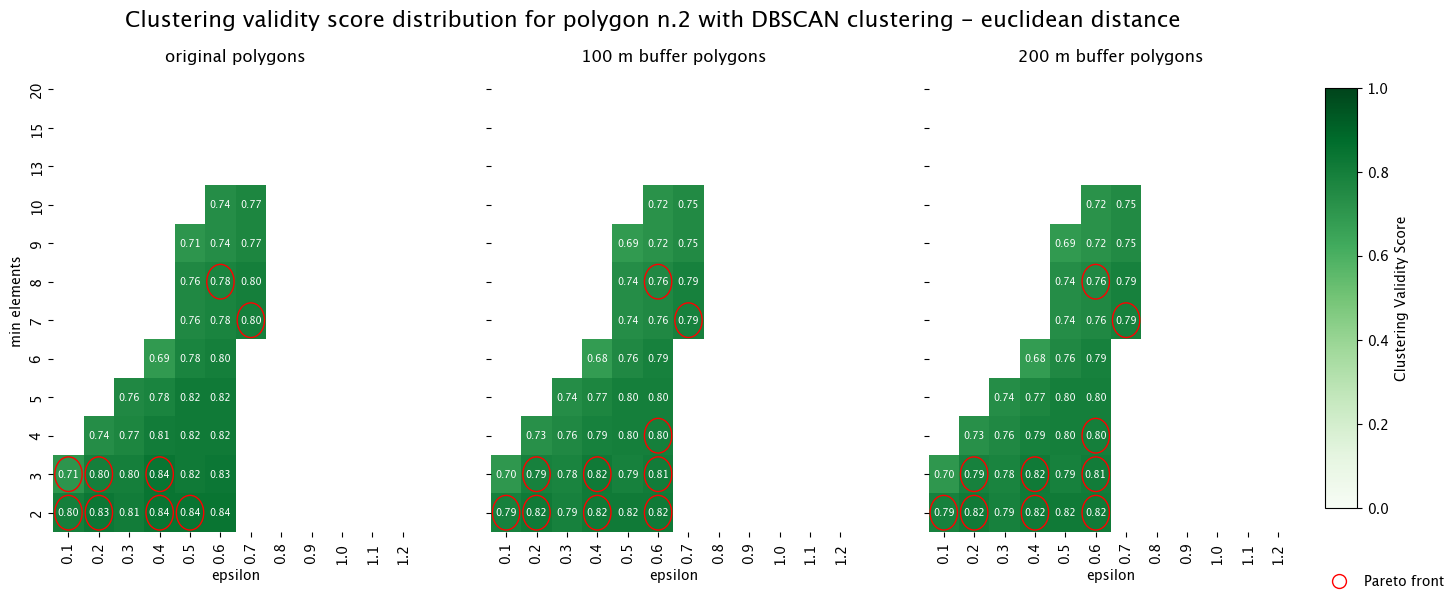

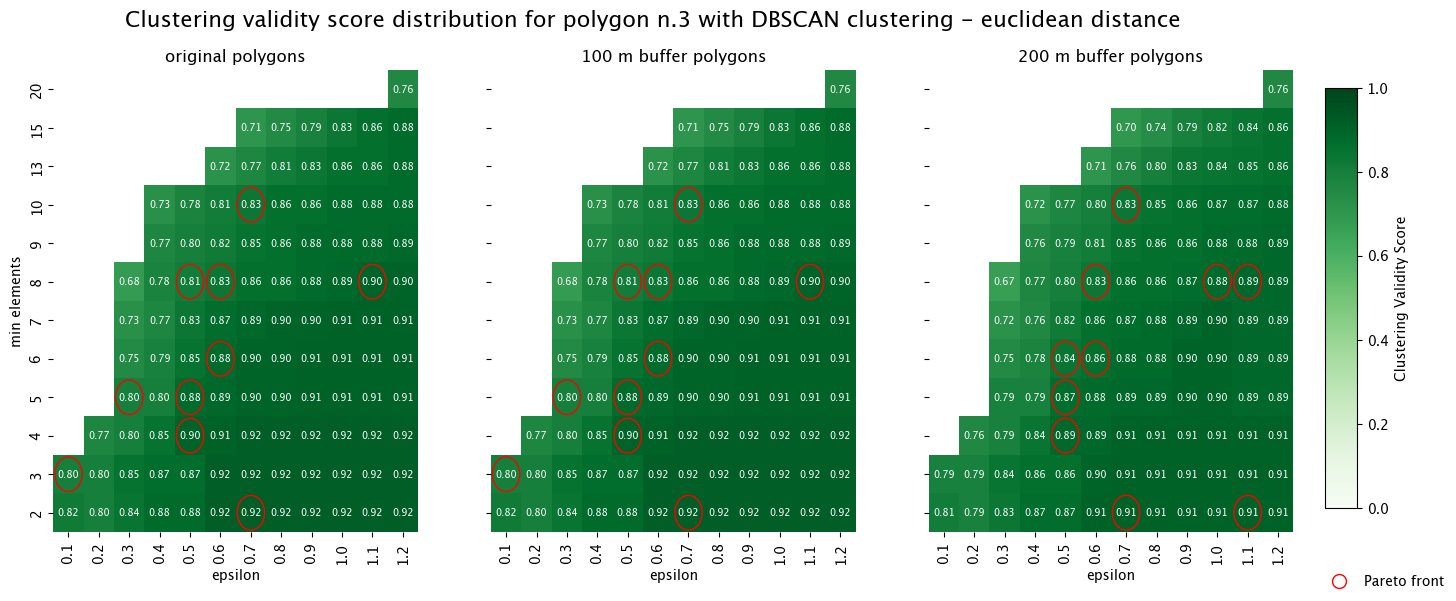

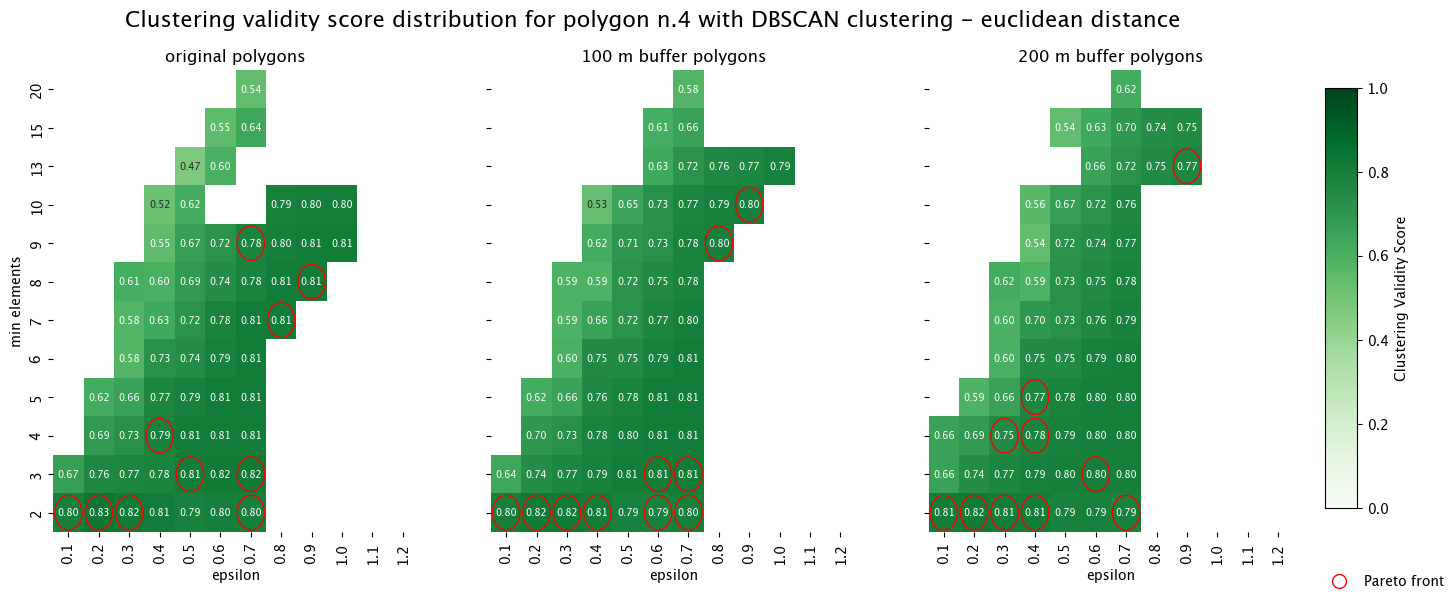

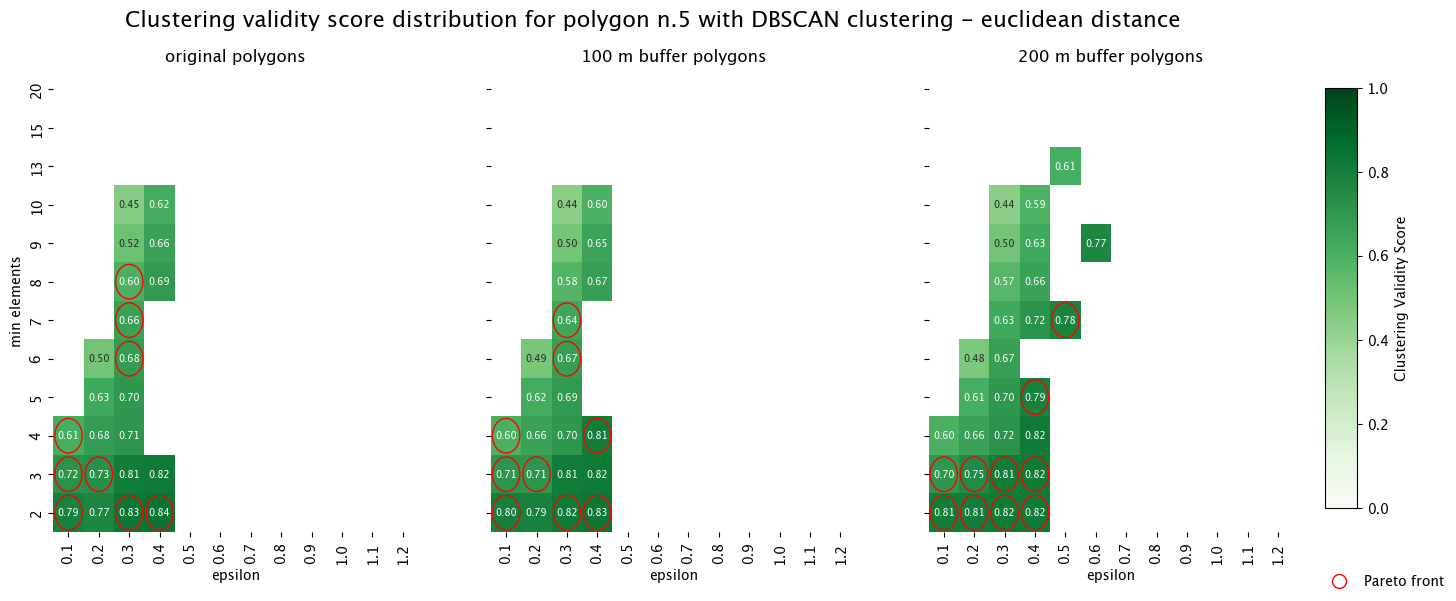

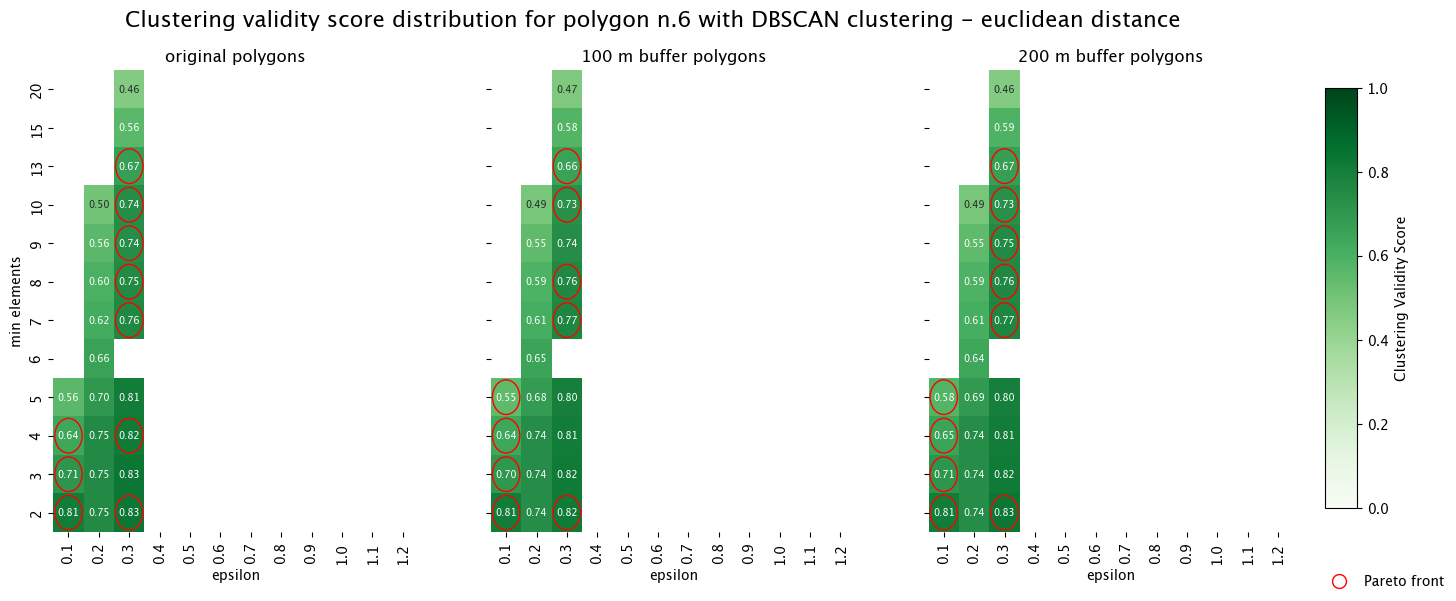

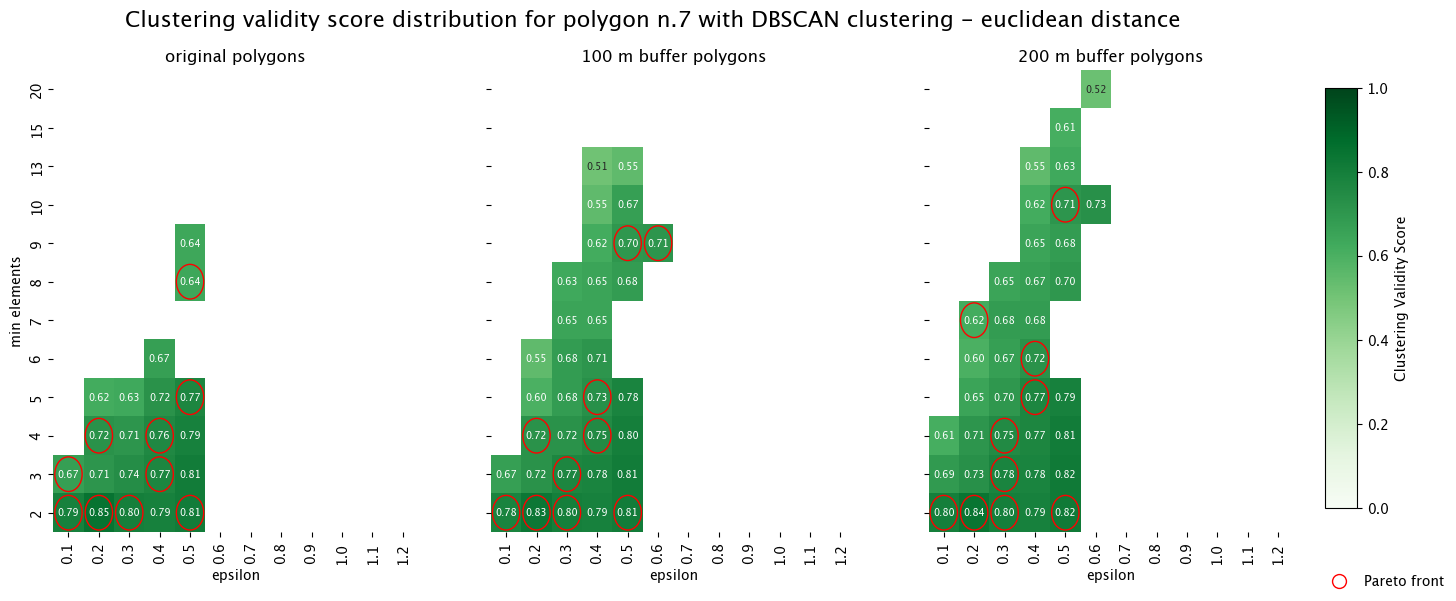

Stored the Clustering Validity Score heatmap with Pareto points highlighted.


In [37]:
cvs_heatmap = []

for pol in sorted(data.polygon_id.unique()):
    
    all_eps = np.arange(0.1, 1.3, 0.1)
    
    # obtain subsets
    res_original = data_original[data_original['polygon_id'] == pol].dropna(subset=['cvs'])
    res_buffer100 = data_buffer100[data_buffer100['polygon_id'] == pol].dropna(subset=['cvs'])
    res_buffer200 = data_buffer200[data_buffer200['polygon_id'] == pol].dropna(subset=['cvs'])
    
    # get pareto subset for this polygon
    pareto_pol = pareto_complete[pareto_complete['polygon_id'] == pol]

    # pivot and reindex
    original_pivot = res_original.pivot(index='el', columns='eps', values='cvs').reindex(index=min_elements_parameter, columns=epsilon_parameter)
    buffer100_pivot = res_buffer100.pivot(index='el', columns='eps', values='cvs').reindex(index=min_elements_parameter, columns=epsilon_parameter)
    buffer200_pivot = res_buffer200.pivot(index='el', columns='eps', values='cvs').reindex(index=min_elements_parameter, columns=epsilon_parameter)
    
    # annotations formatting 
    original_annots = original_pivot.stack().map(cleanup_format).unstack().reindex(index=original_pivot.index, columns=original_pivot.columns).fillna('')
    buffer100_annots = buffer100_pivot.stack().map(cleanup_format).unstack().reindex(index=buffer100_pivot.index, columns=buffer100_pivot.columns).fillna('')
    buffer200_annots = buffer200_pivot.stack().map(cleanup_format).unstack().reindex(index=buffer200_pivot.index, columns=buffer200_pivot.columns).fillna('')
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    
    vmin, vmax = 0.0, 1.0
             
    # now call the helper for each dataset
    plot_heatmap_with_pareto(axes[0], original_pivot, original_annots,
                             "original polygons",
                             pareto_pol[pareto_pol.buffer=='original'])

    plot_heatmap_with_pareto(axes[1], buffer100_pivot, buffer100_annots,
                             "100 m buffer polygons",
                             pareto_pol[pareto_pol.buffer=='buffer_100'])

    plot_heatmap_with_pareto(axes[2], buffer200_pivot, buffer200_annots,
                             "200 m buffer polygons",
                             pareto_pol[pareto_pol.buffer=='buffer_200'])

    axes[0].set_ylabel("min elements")
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")
    
    # shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cmap = plt.get_cmap('Greens')
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label('Clustering Validity Score')
    
    legend_circle = Line2D([0], [0], marker='o', color='w', label='Pareto front',
                       markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=1)
    fig.legend(handles=[legend_circle], loc='lower right', frameon=False, ncol=1)
    
    
    plt.subplots_adjust(top=0.88, right=0.9)
    plt.suptitle(f"Clustering validity score distribution for polygon n.{pol} with DBSCAN clustering - euclidean distance", fontsize=16)
    plt.show()
        
    # save figure to buffer and collect as PIL Image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    cvs_heatmap.append(img)
    plt.close(fig)

# merge all the results together
total_height = sum(img.height for img in cvs_heatmap)
max_width = max(img.width for img in cvs_heatmap)

merged_image = Image.new('RGB', (max_width, total_height), (255, 255, 255))
y_offset = 0
for img in cvs_heatmap:
    merged_image.paste(img, (0, y_offset))
    y_offset += img.height

merged_image.save("images/dbscaneu_cvs_pareto.png")

print("Stored the Clustering Validity Score heatmap with Pareto points highlighted.")
